In [73]:
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
# FUNCTIONS

def beta(stock,etf ):
    # Beta = covariance/variance   --- https://www.investopedia.com/terms/b/beta.asp ---
    cov_matrix = np.cov(stock, etf, ddof=0)
    var_stock = cov_matrix[0,0]
    cov_stock_etf = cov_matrix[0,1]
    return cov_stock_etf/var_stock

def sharpe_ratio(benchmark_returns, portfolio_returns):
    # ---      https://www.educba.com/sharpe-ratio-formula/    --- 
    # Sharpe Ratio = (expected rate of return of portfolio - risk free rate)/standard deviation of portfolio return
    # To be adjusted for interval used. Here, adjust by sqrt(252)
    portfolio_mean_return = portfolio_returns.mean()
    risk_free_rate = benchmark_returns.mean()
    volatility = portfolio_returns.std()
    return ((portfolio_mean_return - risk_free_rate)/volatility) * (252**0.5)

def drawdown(stock_close): # returns weekly drawdown
    weekly_data = stock_close.resample('7D').ffill() # borrowed from: https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
    rolling_max = weekly_data.rolling(window=52,min_periods=1).max() # 52-week high
    return (weekly_data - rolling_max)/rolling_max # difference between current price and current max as ratio of current max

In [75]:
etfs = ['DIA','IWM','SPY']
stocks = ['AMD', 'BRK-B','DIS','LAC','META','TSM','UAL']
stock_cols = ['Ticker', 'Portfolio_Weight', 'Annualized_Volatility','Beta_Against_SPY','Beta_Against_IWM','Beta_Against_DIA',
'Avg_Weekly_Drawdown','Max_Weekly_Drawdown','Total_Return','Annualized_Total_Return']

n = len(stocks)
weight = 1/n

In [76]:
data = yf.download(stocks+etfs, period='10y')
data = data['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [77]:
# REQUIREMENT 1: CONSTITUENT STOCK RISK ANALYSIS

# Create stocks dataframe
stocks_df = pd.DataFrame(columns=stock_cols)
stocks_df['Ticker'] = stocks
i = 0
for ticker in stocks:
    stock = data[ticker]
    stocks_df.at[i, 'Ticker'] = ticker
    stocks_df.at[i, 'Portfolio_Weight'] = weight 
    stocks_df.at[i, 'Annualized_Volatility'] = stock[-63:].std()*(252**0.5) 
    stocks_df.at[i, 'Beta_Against_SPY'] = beta(stock[-252: ], data['SPY'][-252: ])
    stocks_df.at[i, 'Beta_Against_IWM'] = beta(stock[-252: ], data['IWM'][-252: ])
    stocks_df.at[i, 'Beta_Against_DIA'] = beta(stock[-252: ], data['DIA'][-252: ])
    stocks_df.at[i, 'Avg_Weekly_Drawdown'] = drawdown(stock).mean()
    stocks_df.at[i, 'Max_Weekly_Drawdown'] = drawdown(stock).min()
    # --- RETURNS ---( www.corporatefinanceinstitute.com )
    # Absolute return = (final price - initial price)/initial price 
    # Annualized Total return = (((final value/initial value)^(1/n)) - 1) 
    stocks_df.at[i, 'Total_Return'] = (stock[-1] - stock[0])/stock[0] 
    stocks_df.at[i, 'Annualized_Total_Return'] = (((stock[-1]/stock[0])**(1/10))-1)
    i = i + 1

stocks_df

,Ticker,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return
0,AMD,0.142857,113.404365,1.078184,0.449893,0.315544,-0.180328,-0.640049,31.471074,0.416282
1,BRK-B,0.142857,77.21581,0.821277,0.362189,0.531654,-0.056979,-0.26477,1.990495,0.115769
2,DIS,0.142857,129.712433,1.26505,0.589837,0.404951,-0.109795,-0.487617,0.980314,0.070714
3,LAC,0.142857,35.103984,3.573438,1.712607,1.002278,-0.30411,-0.700617,28.4875,0.402697
4,META,0.142857,406.231263,0.443016,0.170139,0.080772,-0.116123,-0.737069,5.297336,0.202031
5,TSM,0.142857,120.504088,1.628241,0.704047,0.716373,-0.097001,-0.552172,5.41085,0.20418
6,UAL,0.142857,77.428044,1.870008,0.952104,1.883307,-0.17999,-0.787701,0.897736,0.066163


In [78]:
# REQUIREMENT 2: PORTFOLIO RISK VS ETFS

portfolio_vs_etf_cols = ['Ticker', 'Corr_against_ETF', 'Cov_against_ETF', 'Tracking_Errors', 'Sharpe_Ratio', 'Ann_Volatility_Spread']
portfolio_against_etf_df = pd.DataFrame(columns=portfolio_vs_etf_cols)
portfolio_against_etf_df['Ticker'] = etfs

In [79]:
portfolio = data[stocks]
portfolio_returns = portfolio.pct_change() 
portfolio_returns = portfolio_returns * weight # weighted portfolio returns
portfolio_returns = portfolio_returns.sum(axis=1) # year-on-year portfolio pct change


In [80]:
returns_all_df = pd.concat([data[etfs].pct_change(), data[stocks].pct_change(), portfolio_returns], axis=1) # df of all returns (etf, stocks, portfolio)
cols = etfs + stocks
cols.append('Portfolio')
returns_all_df.columns = cols
corr_matrix = returns_all_df.corr(method="pearson")
cov_matrix = returns_all_df.cov()

In [81]:
j = 0
for etf in etfs:
    portfolio_against_etf_df.at[j, 'Ticker'] = etf
    portfolio_against_etf_df.at[j, 'Corr_against_ETF'] = corr_matrix['Portfolio'][etf]
    portfolio_against_etf_df.at[j, 'Cov_against_ETF'] = cov_matrix['Portfolio'][etf]
    # --- https://www.investopedia.com/terms/t/trackingerror.asp ---
    # Tracking Error = std(portfolio_returns - benchmark returns)
    portfolio_against_etf_df.at[j, 'Tracking_Errors'] = (returns_all_df['Portfolio'] - returns_all_df[etf]).std()
    # Sharpe Ratio: using info from 1 years worth of data. Can't use already calculated returns
    portfolio_against_etf_df.at[j, 'Sharpe_Ratio'] = sharpe_ratio(returns_all_df[etf], returns_all_df['Portfolio']) 
    portfolio_against_etf_df.at[j, 'Ann_Volatility_Spread'] = ((returns_all_df['Portfolio'].std())*(252**0.5)) - ((returns_all_df[etf].std())*(252**0.5))
    j = j+1

portfolio_against_etf_df

,Ticker,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
0,DIA,0.70193,0.000142,0.013312,0.665083,0.11946
1,IWM,0.737248,0.000187,0.012481,0.701981,0.075616
2,SPY,0.747046,0.000152,0.012598,0.634618,0.11874


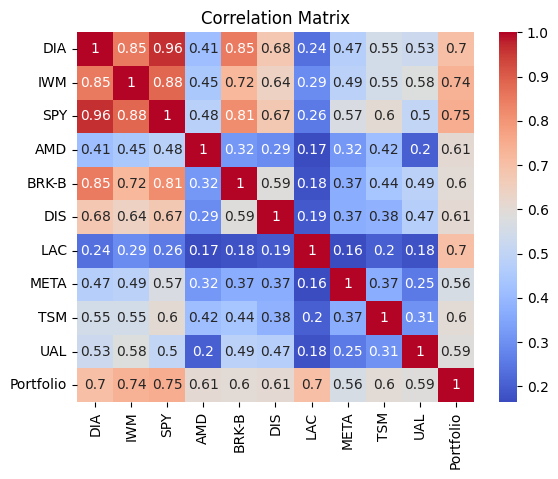

In [82]:
# REQUIREMENT NUMBER 3: CORRELATION MATRIX

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [83]:
stocks_df = stocks_df.style.set_caption('CONSTITUENT STOCK RISK ANALYSIS')
stocks_df

,Ticker,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return
0,AMD,0.142857,113.404365,1.078184,0.449893,0.315544,-0.180328,-0.640049,31.471074,0.416282
1,BRK-B,0.142857,77.215810,0.821277,0.362189,0.531654,-0.056979,-0.264770,1.990495,0.115769
2,DIS,0.142857,129.712433,1.265050,0.589837,0.404951,-0.109795,-0.487617,0.980314,0.070714
3,LAC,0.142857,35.103984,3.573438,1.712607,1.002278,-0.304110,-0.700617,28.487500,0.402697
4,META,0.142857,406.231263,0.443016,0.170139,0.080772,-0.116123,-0.737069,5.297336,0.202031
5,TSM,0.142857,120.504088,1.628241,0.704047,0.716373,-0.097001,-0.552172,5.410850,0.204180
6,UAL,0.142857,77.428044,1.870008,0.952104,1.883307,-0.179990,-0.787701,0.897736,0.066163


In [84]:
portfolio_against_etf_df = portfolio_against_etf_df.style.set_caption('PORTFOLIO RISK VS ETFS')
portfolio_against_etf_df

,Ticker,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
0,DIA,0.701930,0.000142,0.013312,0.665083,0.119460
1,IWM,0.737248,0.000187,0.012481,0.701981,0.075616
2,SPY,0.747046,0.000152,0.012598,0.634618,0.118740
